In [1]:
#data preparation
from utils import read_data

data = read_data(keep_dates=False)
df_all = data.train_val_df
df_test = data.test_df
df_test = df_test.drop(columns=["time_stamp","station"])
df_all = df_all.drop(columns=["time_stamp","station"])
df_all.columns

Loaded  data\PRSA_Data_Aotizhongxin_20130301-20170228.csv
Loaded  data\PRSA_Data_Changping_20130301-20170228.csv
Loaded  data\PRSA_Data_Dingling_20130301-20170228.csv
Loaded  data\PRSA_Data_Dongsi_20130301-20170228.csv
Loaded  data\PRSA_Data_Guanyuan_20130301-20170228.csv
Loaded  data\PRSA_Data_Gucheng_20130301-20170228.csv
Loaded  data\PRSA_Data_Huairou_20130301-20170228.csv
Loaded  data\PRSA_Data_Nongzhanguan_20130301-20170228.csv
Loaded  data\PRSA_Data_Shunyi_20130301-20170228.csv
Loaded  data\PRSA_Data_Tiantan_20130301-20170228.csv
Loaded  data\PRSA_Data_Wanliu_20130301-20170228.csv
Loaded  data\PRSA_Data_Wanshouxigong_20130301-20170228.csv
Applied normalization on  ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
Applied normalization on  ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']


Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM', 'WD_E', 'WD_ENE', 'WD_ESE', 'WD_N', 'WD_NE', 'WD_NNE',
       'WD_NNW', 'WD_NW', 'WD_S', 'WD_SE', 'WD_SSE', 'WD_SSW', 'WD_SW', 'WD_W',
       'WD_WNW', 'WD_WSW'],
      dtype='object')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tud
import numpy as np

class MLPDataset(tud.Dataset):
    def __init__(self, data):
        self.y = data["PM2.5"].values
        self.x = data[data.columns[1:]].values
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.y[idx], self.x[idx]

In [4]:
model = nn.Sequential(
    nn.Linear(26,10),
    nn.ReLU(),
    nn.Linear(10, 3),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(3, 1)
)


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 1e-3
batch_size = 300
epochs = 80
test_interval = 5
log_interval = 1000

model = model.to(device).double()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mlpDataset = MLPDataset(df_all)
train_set, validation_set = torch.utils.data.random_split(mlpDataset, [len(mlpDataset) - 64000, 64000])
train_dataloader = tud.DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_dataloader = tud.DataLoader(validation_set, batch_size=batch_size)

In [6]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    
    losses = []
    for batch_idx, (y ,x) in enumerate(train_loader):
        y = y.to(device).double()
        x = x.to(device)
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = F.mse_loss(output, y.view(-1,1))
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, (batch_idx + 1) * batch_size, len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    return losses

In [7]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

def test(model, device, test_loader):
    model.eval()
    mse_losses = []
    mae_losses = []
    rmse_losses = []
    accuracy10 = []
    accuracy20 = []
    accuracy50 = []
    accuracy100 = []

    for batch_idx, (y ,x) in enumerate(test_loader):
        y = y.to(device).double().view(-1,1)
        x = x.to(device)
        
        with torch.no_grad():
            output = model(x)
            
            mse_loss = F.mse_loss(output, y)
            mse_losses.append(mse_loss.item())
            mae_loss =F.l1_loss(output, y)
            mae_losses.append(mae_loss)
            criterion = RMSELoss()
            rmse_loss = criterion(output, y)
            rmse_losses.append(rmse_loss)
            
            diff = output - y
            accuracy10.append(len(diff[abs(diff)<=10]))
            accuracy20.append(len(diff[abs(diff)<=20]))
            accuracy50.append(len(diff[abs(diff)<=50]))
            accuracy100.append(len(diff[abs(diff)<=100]))

    
    data_size = len(test_loader.dataset)
    print(float(sum(mse_losses))/len(mse_losses), float(sum(rmse_losses))/len(rmse_losses),
          float(sum(mae_losses))/len(mae_losses))
    
    print (float(sum(accuracy10))/data_size, float(sum(accuracy20))/data_size,
          float(sum(accuracy50))/data_size, float(sum(accuracy100))/data_size)
    
    return float(sum(mse_losses))/len(mse_losses), float(sum(rmse_losses))/len(rmse_losses),\
           float(sum(mae_losses))/len(mae_losses),\
           float(sum(accuracy10))/data_size, float(sum(accuracy20))/data_size,\
           float(sum(accuracy50))/data_size, float(sum(accuracy100))/data_size
        
            
    

In [8]:
epoch_losses = []
epoch_test_acc10 = []
epoch_test_acc20 = []
epoch_test_acc50 = []
epoch_test_acc100 = []
for epoch in range(epochs):
    loss = train(model, device, train_dataloader, optimizer, epoch, log_interval)
    epoch_losses.append(loss)
    mse_losses, rmse_losses, mae_losses, acc10, acc20, acc50, acc100 = test(model, device, validation_dataloader)
    epoch_test_acc10.append(acc10)
    epoch_test_acc20.append(acc20)
    epoch_test_acc50.append(acc50)
    epoch_test_acc100.append(acc100)
    if epoch + 1 == 20:
        torch.save(model.state_dict(), "mlp_epoch_{}.pt".format(epoch+1))
torch.save(model.state_dict(), "mlp_epoch_{}.pt".format(epoch+1))

5378.838941094829 73.08851244110747 50.45165197741448
0.1176875 0.2370625 0.719625 0.8881875
3077.0142511065633 55.254674001777424 37.30532166371611
0.17778125 0.377703125 0.805765625 0.930046875
1693.4637835442834 40.990519122563065 26.85624839843136
0.330265625 0.558703125 0.85803125 0.96284375
1353.2955343817412 36.651780654202305 24.080983606334122
0.3668125 0.604984375 0.87578125 0.97265625
1223.8208071640458 34.85649345057178 22.844053712527234
0.3909375 0.627984375 0.88471875 0.976140625
1118.2550688599972 33.3168172891529 21.814843187739495
0.40703125 0.643109375 0.89346875 0.979375
1075.0722067066508 32.660954980515015 21.301993829518224
0.41171875 0.647640625 0.89684375 0.981
1054.4628848909522 32.34082147908096 21.07192050934765
0.4188125 0.649453125 0.8989375 0.982171875
1019.9563712217297 31.79814800547533 20.665354629634056
0.42640625 0.654171875 0.9026875 0.983421875
1029.472228918446 31.94376374626487 20.72501353764624
0.43021875 0.6523125 0.90153125 0.9833125
1020.9561

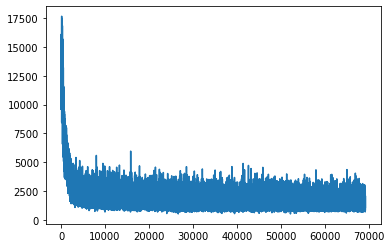

In [10]:
import matplotlib.pyplot as plt
A = np.array(epoch_losses)
plt.plot(A.flatten())

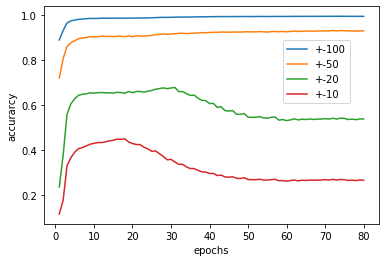

In [11]:
B = np.array(epoch_test_acc100)
C = np.array(epoch_test_acc50)
D = np.array(epoch_test_acc20)
E = np.array(epoch_test_acc10)
x = range(1,81)
plt.plot(x, B.flatten(), label = "+-100")
plt.plot(x, C.flatten(), label = "+-50")
plt.plot(x, D.flatten(), label = "+-20")
plt.plot(x, E.flatten(), label = "+-10")
plt.xlabel('epochs')
plt.ylabel('accurarcy')
plt.legend(bbox_to_anchor=(0.7, 0.7))
plt.show()

In [13]:
model.load_state_dict(torch.load("mlp_epoch_20.pt"))
model.to(device)
test_dataset = MLPDataset(df_test)
test_dataloader = tud.DataLoader(validation_set, batch_size=batch_size)
mse_losses, rmse_losses, mae_losses, acc10, acc20, acc50, acc100 = test(model, device, test_dataloader)

999.8800191035142 31.489019422704626 20.636495493957252
0.42946875 0.654546875 0.902765625 0.984359375
